Created: 2020.07.22

Modified: 2020.07.27

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import random
import pandas as pd
from pathlib import Path

import sys
sys.path.append('../functions')
import functions32 as f32

# 2D AXIAL

In [8]:
folder_path = Path('/data-10tb/shared/skull/axial-2d/')

df_full = pd.read_csv(folder_path/'bias_mask-test-val-axial-2d.csv')
print(df_full.shape)
#df_full.head()

(469116, 6)


#### Select part of the whole df

In [9]:
df = f32.split_data(df_full, pct_rand_both=0.003, nr_beg_both=None)
df.shape

Original df=469116:	train=1074, val=334,	train+val=1408, df*pct_rand_both=1407.3


(1408, 6)

#### Create a DataBunch v.1

In [10]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [11]:
src = SegmentationItemList.from_df(df, folder_path, cols='bias_path')\
                            .split_from_df(col='usage')\
                            .label_from_df(cols='mask_full_path', classes=codes)

In [12]:
size = 64
bs = 32

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

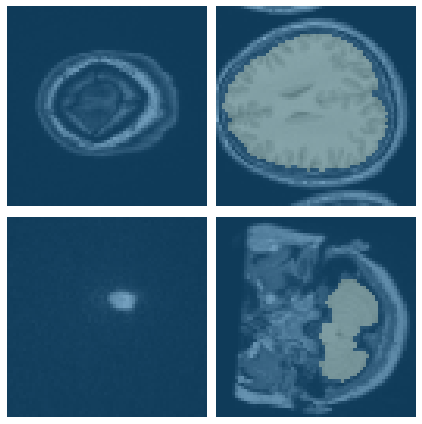

In [14]:
data.show_batch(2, figsize=(6,6))

In [59]:
#torch.cuda.empty_cache()
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [15]:
wd=1e-2

In [16]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 3.02E-04


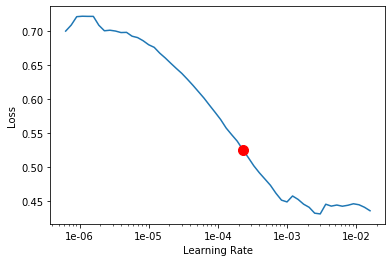

In [63]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

### LR=1e-4

In [64]:
lr=1e-3

In [65]:
learn.fit_one_cycle(25, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.251945,0.134245,0.717188,00:08
1,0.167135,0.092833,0.795310,00:05
2,0.130904,0.088365,0.815709,00:06
3,0.104703,0.067735,0.841361,00:06
4,0.098852,0.074426,0.835819,00:05
5,0.083692,0.058986,0.849999,00:06
6,0.072485,0.053143,0.870076,00:06
7,0.071455,0.063744,0.858433,00:05
8,0.065527,0.075273,0.841855,00:05
9,0.062479,0.051434,0.875388,00:05


In [66]:
save = 0
# trening-axial/fit-one-cycle-5/lr=1e-5/freeze/splid-data-pct-rand-both-0.p003-images
sname1 = 'train-ax_rf_foc-25_lr-slice-1e4_fr_sd-pct-rand-both-0p003'
if save:    
    learn.save(sname1)

In [67]:
#learn.load(sname1);

In [68]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.036507,0.042341,0.899008,00:05
1,0.037178,0.043636,0.896677,00:06
2,0.041134,0.048711,0.890359,00:05
3,0.045967,0.059476,0.870203,00:05
4,0.049158,0.058024,0.885375,00:05
5,0.049022,0.050744,0.890351,00:05
6,0.048168,0.046810,0.879306,00:05
7,0.045310,0.044767,0.890257,00:05
8,0.042605,0.043887,0.898297,00:06
9,0.041278,0.043404,0.898024,00:06


In [69]:
save = 0
if save:
    sname2 = 'train-ax_fr_foc-30_lr-slice-1e4_fr_sd-pct-rand-both-0p003'
    learn.save(sname2)

In [70]:
#learn.load(sname2);

In [71]:
#learn.show_results(rows=2, figsize=(6,6))

In [72]:
#learn.recorder.plot_losses()

In [73]:
#learn.recorder.plot_lr()

In [74]:
#learn.recorder.plot_metrics()

#### Unfreeze

In [75]:
#learn.load(sname2);

In [76]:
learn.unfreeze()

In [77]:
lrs = slice(lr/10,lr/4)

In [78]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.034258,0.040718,0.901281,00:06
1,0.034550,0.040643,0.893354,00:05
2,0.035324,0.040542,0.895033,00:06
3,0.035043,0.040736,0.897029,00:06
4,0.034829,0.042525,0.895297,00:06
5,0.034720,0.042850,0.882846,00:06
6,0.035587,0.041696,0.895212,00:06
7,0.035922,0.046508,0.895533,00:06
8,0.036995,0.040965,0.897679,00:06
9,0.035484,0.042452,0.899874,00:06


In [79]:
save = 0
if save:
    sname3 = 'train-ax_uf_foc-40_lr-slice-1e4_sd-pct-rand-both-0p003'
    learn.save(sname3)

In [80]:
#learn.load(sname3);

## [Prediction](https://docs.fast.ai/basic_train.html#fit_one_cycle)


#### v1

In [5]:
img = open_image('/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208112603927_S9136_I32246.anat/T1_biascorr_brain_mask_iso_nn_000.png', convert_mode='L')

In [6]:
print(img.shape, type(img))

torch.Size([1, 192, 241]) <class 'fastai.vision.image.Image'>


torch.Size([1, 64, 64]) <class 'fastai.vision.image.ImageSegment'>


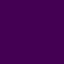

In [17]:
prediction = learn.predict(img)[0]
print(prediction.shape, type(prediction))
prediction

torch.Size([1, 192, 241])


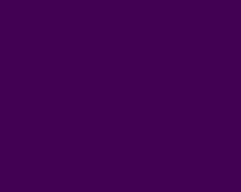

In [18]:
print(img.shape)
img

#### v2

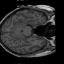

In [19]:
data = learn.data.train_ds[100][0]
data

In [20]:
pred = learn.predict(data)
print('prediction:', len(pred), type(pred), '\n')
for k in pred:
    print(k.shape, type(k))

prediction: 3 <class 'tuple'> 

torch.Size([1, 64, 64]) <class 'fastai.vision.image.ImageSegment'>
torch.Size([1, 64, 64]) <class 'torch.Tensor'>
torch.Size([2, 64, 64]) <class 'torch.Tensor'>


## Images in prediction

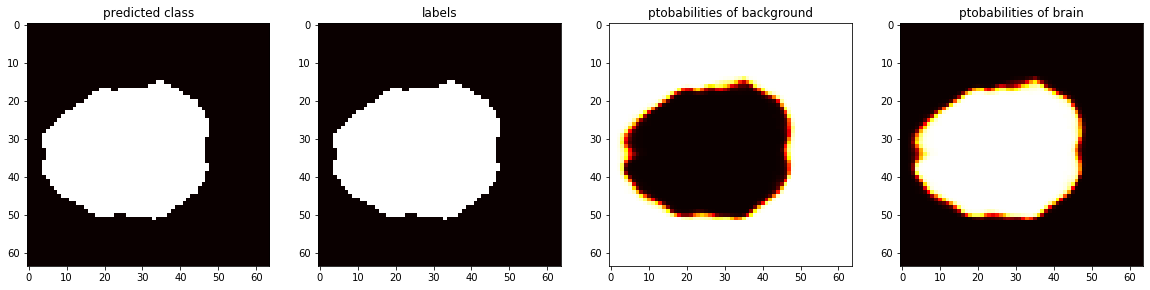

In [87]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,4,figsize=(20,8))

cm = 'hot'
p0 = pred[0].data.numpy()
ax[0].imshow(p0[0,...], cmap=cm)
ax[0].set_title('predicted class')

p1 = pred[1].data.numpy()
ax[1].imshow(p1[0,...], cmap=cm)
ax[1].set_title('labels')

p2 = pred[2].data.numpy()
ax[2].imshow(p2[0,...], cmap=cm)
ax[2].set_title('ptobabilities of background')

p3 = pred[2].data.numpy()
ax[3].imshow(p2[1,...], cmap=cm)
ax[3].set_title('ptobabilities of brain')

f.show()

In [88]:
# Return predictions and targets on ds_type dataset
aa = learn.get_preds()

In [89]:
print(type(aa), len(aa))
for k in range(len(aa)): 
    print(len(aa[k]), type(aa[k]), aa[k].shape)

<class 'list'> 2
294 <class 'torch.Tensor'> torch.Size([294, 2, 64, 64])
294 <class 'torch.Tensor'> torch.Size([294, 1, 64, 64])


In [90]:
print(len(learn.data.valid_ds), len(learn.data.train_ds))

294 983


In [91]:
bb = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)

In [92]:
print(type(bb), len(bb))
for k in range(len(bb)): 
    print(len(bb[k]), type(bb[k]), bb[k].shape)

<class 'list'> 3
960 <class 'torch.Tensor'> torch.Size([960, 2, 64, 64])
960 <class 'torch.Tensor'> torch.Size([960, 1, 64, 64])
3932160 <class 'torch.Tensor'> torch.Size([3932160])


In [93]:
14221312/128/128

868.0

In [94]:
cc = np.array(bb[2].reshape(868,128,128))
print(cc.min(), cc.max())
plt.imshow(cc[255,:,:],cmap='gray')

RuntimeError: shape '[868, 128, 128]' is invalid for input of size 3932160

In [95]:
dd = learn.get_preds(ds_type=DatasetType.Train, with_loss=True, n_batch=2)

In [96]:
print(type(dd), len(dd))
for k in range(len(dd)): 
    print(len(dd[k]), type(dd[k]), dd[k].shape)
    
print(868/124)
print(124*2)

<class 'list'> 3
64 <class 'torch.Tensor'> torch.Size([64, 2, 64, 64])
64 <class 'torch.Tensor'> torch.Size([64, 1, 64, 64])
262144 <class 'torch.Tensor'> torch.Size([262144])
7.0
248


# Infering

## Try to train on original image size 

Very important link to the forum question about this issue: [link](https://forums.fast.ai/t/segmentation-mask-prediction-on-different-input-image-sizes/44389)

#### v3

In [22]:
img = open_image('/data-10tb/shared/skull/axial-2d/train/SLIM/sub-25632_ses-1_T1w.anat/T1_biascorr_iso_011.png')

In [23]:
img.shape

torch.Size([3, 176, 256])

In [24]:
#learn.data.train_ds.tfmargs
learn.data.single_dl.dataset.tfmargs['size'] = img.shape

torch.Size([1, 176, 256])


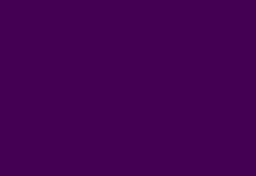

In [25]:
prediction = learn.predict(img)[0]
print(prediction.shape)
prediction

In [101]:
type(prediction)

fastai.vision.image.ImageSegment

In [ ]:
prediction.save('xxxx.png')

In [ ]:
pwd